# Import Libraries

In [1]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.5 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=490528514145dcdb5b185eb160ebea2165375df2c25477aa60aca56b74d3f4e8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=145edef2b6cfd82f129eec012ff4db93428e3d48d8c62903e4f578dc0220aa90
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [2]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import warnings
warnings.filterwarnings('ignore')
import torchvision.utils as vutils
from torchvision import models

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [3]:
import os
import cv2
import hashlib
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from PIL import Image, ImageDraw, ImageFont

# Data preprocessing

In [4]:

import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class jointDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [6]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "image", "*.png")))
    train_y = sorted(glob(os.path.join(path, "train", "mask", "*.png")))

    test_x = sorted(glob(os.path.join(path, "test", "image", "*.png")))
    test_y = sorted(glob(os.path.join(path, "test", "mask", "*.png")))

    return (train_x, train_y), (test_x, test_y)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/kaggle/input/origia-joint/jointSeg_dataset/ORIGA"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 500 - 500
Test: 150 - 150


In [5]:
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Model

In [6]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * s

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c, out_c)
        self.c1 = conv_block(in_c[0]+out_c, out_c)

    def forward(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.c1(x)
        return x

class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)

        self.b1 = conv_block(256, 512)

        self.d1 = decoder_block([512, 256], 256)
        self.d2 = decoder_block([256, 128], 128)
        self.d3 = decoder_block([128, 64], 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)

        b1 = self.b1(p3)

        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output(d3)
        return output


if __name__ == "__main__":
    x = torch.randn((8, 3, 256, 256))
    model = attention_unet()
    output = model(x)
    print(output.shape)

torch.Size([8, 1, 256, 256])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

def calculate_accuracy(outputs, masks):
    predicted = outputs > 0.5  # Assuming binary classification
    correct = (predicted == masks.byte()).float()  # Convert masks to byte tensor for comparison
    accuracy = correct.sum() / torch.numel(masks)
    return accuracy.item()

def calculate_dice_coefficient(outputs, masks):
    smooth = 1e-6  # Smoothing factor to avoid division by zero
    predicted = outputs > 0.5  # Assuming binary classification
    intersection = (predicted & masks.byte()).float().sum()
    union = predicted.float().sum() + masks.float().sum()
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient.item()

In [9]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_dice = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        dice = calculate_dice_coefficient(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_dice += dice

    epoch_loss = epoch_loss / len(loader)
    epoch_acc = epoch_acc / len(loader)
    epoch_dice = epoch_dice / len(loader)
    return epoch_loss, epoch_acc, epoch_dice

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_dice = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            dice = calculate_dice_coefficient(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc
            epoch_dice += dice

        epoch_loss = epoch_loss / len(loader)
        epoch_acc = epoch_acc / len(loader)
        epoch_dice = epoch_dice / len(loader)
    return epoch_loss, epoch_acc, epoch_dice

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    all_train_x = sorted(glob("/kaggle/input/origia-joint/jointSeg_dataset/ORIGA/train/image/**/*.png", recursive=True))
    all_train_y = sorted(glob("/kaggle/input/origia-joint/jointSeg_dataset/ORIGA/train/mask/**/*.png", recursive=True))

    # Splitting train dataset into train and validation sets
    train_x, valid_x, train_y, valid_y = train_test_split(all_train_x, all_train_y, test_size=0.2, random_state=42)

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 256
    W = 256
    size = (H, W)
    batch_size = 2
    num_epochs = 25
    lr = 1e-4
    checkpoint_path = "files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = jointDataset(train_x, train_y)
    valid_dataset = jointDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=3
    )

    device = torch.device('cuda')   ## GTX 1060 6GB
    model = attention_unet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_dice = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_acc, valid_dice = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Train Dice: {train_dice:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc:.3f} | Val. Dice: {valid_dice:.3f}\n'
        print(data_str)

Dataset Size:
Train: 400 - Valid: 100

Valid loss improved from inf to 0.5405. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 1m 1s
	Train Loss: 0.549 | Train Acc: 0.920 | Train Dice: 0.846
	 Val. Loss: 0.540 | Val. Acc: 0.917 | Val. Dice: 0.844

Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.465 | Train Acc: 0.939 | Train Dice: 0.867
	 Val. Loss: 0.633 | Val. Acc: 0.913 | Val. Dice: 0.841

Valid loss improved from 0.5405 to 0.5215. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 1m 0s
	Train Loss: 0.429 | Train Acc: 0.939 | Train Dice: 0.868
	 Val. Loss: 0.522 | Val. Acc: 0.903 | Val. Dice: 0.837

Valid loss improved from 0.5215 to 0.5101. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 0.407 | Train Acc: 0.937 | Train Dice: 0.867
	 Val. Loss: 0.510 | Val. Acc: 0.880 | Val. Dice: 0.830

Epoch: 05 | Epoch Time: 0m 59s
	Train Loss: 0.390 | Train Acc: 0.936 | Train Dice: 0.867
	 Val. Loss: 0.537 | Val. Acc: 0.897 | Val. 

In [10]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

'''from model import build_unet
from utils import create_dir, seeding'''

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("resulT")

    """ Load dataset """
    test_x = sorted(glob("/kaggle/input/origia-joint/jointSeg_dataset/ORIGA/test/image/*"))
    test_y = sorted(glob("/kaggle/input/origia-joint/jointSeg_dataset/ORIGA/test/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = attention_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 150/150 [00:53<00:00,  2.82it/s]

Jaccard: 0.8598 - F1: 0.9221 - Recall: 0.8835 - Precision: 0.9757 - Acc: 0.8791
FPS:  231.4581468576619


# Predict images

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, mask, output):
    """
    Display the input image, ground truth mask, and predicted mask
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    # Plot input image
    input_image_bgr = np.transpose(image.squeeze().cpu().detach().numpy(), (1, 2, 0))[:, :, ::-1]  # RGB to BGR
    
    # Plot input image
    axs[0].imshow(input_image_bgr)
    axs[0].set_title('Input Image (BGR)')
    axs[0].axis('off')
    
    # Plot ground truth mask
    axs[1].imshow(mask.squeeze().cpu().detach().numpy(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')
    
    # Plot predicted mask
    # Plot predicted mask
    axs[2].imshow(output.squeeze().cpu().detach().numpy(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.show()

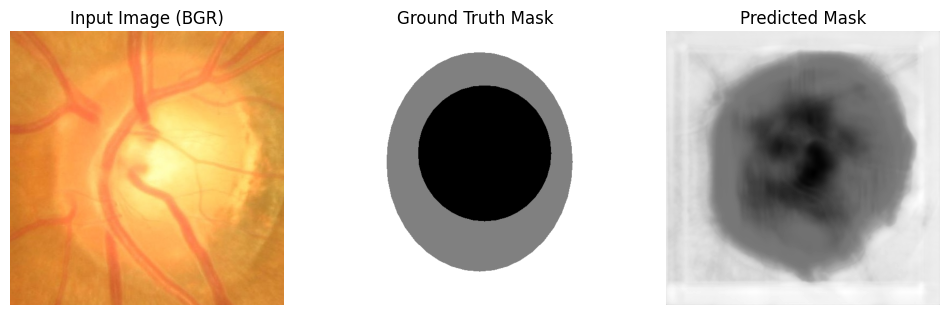

In [12]:
# Assuming you have an image, ground truth mask, and predicted mask tensors
image = x[0]  # Example image from the dataset
mask = y[0]    # Corresponding ground truth mask
output = model(image.unsqueeze(0).to(device))  # Model prediction for the image

# Display the images
display_image(image, mask, output)